In [1]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch as ch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import pickle

from delphi import train
from delphi.utils import model_utils
from delphi.utils.datasets import CIFAR
import delphi.utils.constants as consts
import delphi.utils.data_augmentation as da

# Constants

In [2]:
BASE_CLASSIFIER_PATH = '/home/pstefanou/VGG-11-CIFAR-10/'

TRUNCATED_STORE_PATH = '/home/pstefanou/VGG-11-CIFAR-10/Truncated/'
STANDARD_STORE_PATH = '/home/pstefanou/VGG-11-CIFAR-10/Standard/'

TRUNCATED_EVAL_STORE_PATH = '/home/pstefanou/VGG-11-CIFAR-10/TruncatedTest/'
STANDARD_EVAL_STORE_PATH = '/home/pstefanou/VGG-11-CIFAR-10/StandardTest/'

# Experiment Hyperparameters

In [3]:
args = Parameters({ 
    'epochs': 150,
    'num_workers': 8, 
    'batch_size': 128, 
    'lr': 1e-1, 
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'save_ckpt_iters': 50,
    'should_save_ckpt': True,
    'log_iters': 1,
    'custom_lr_multiplier': consts.COSINE, 
    'validation_split': .8,
    'shuffle': True,
})
if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda:0')
args

{
  "epochs": 150,
  "num_workers": 8,
  "batch_size": 128,
  "lr": 0.1,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "save_ckpt_iters": 50,
  "should_save_ckpt": true,
  "log_iters": 1,
  "custom_lr_multiplier": "cosine",
  "validation_split": 0.8,
  "shuffle": true,
  "device": "cuda:0"
}

In [4]:
ds = CIFAR(data_path='/home/pstefanou/')
model, _ = model_utils.make_and_restore_model(arch='vgg11', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


# Explore Dataset


In [6]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(consts.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

AttributeError: module 'delphi.utils.constants' has no attribute 'CIFAR_LABELS'

# Train Model

In [17]:
# logging store
out_store = store.Store(args.out_dir)
# model
model = vgg11()
# train
final_model = train.train_model(args, model, (train_loader, val_loader), store=out_store, device=args.device)


avg loss: 0.0027908511799387636
avg top 1: 99.95999908447266


In [18]:
reader = CollectionReader(args.out_dir)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 1/1 [00:00<00:00, 79.14it/s]


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,21.854000,1.961156,16.302000,2.449052,12.604882,41e47676-0d3f-4433-b7c4-9a4008e38662
1,2,30.957998,1.757909,25.462000,1.873939,25.448538,41e47676-0d3f-4433-b7c4-9a4008e38662
2,3,45.531998,1.454303,38.160000,1.608956,38.439981,41e47676-0d3f-4433-b7c4-9a4008e38662
3,4,57.801998,1.166993,50.961998,1.323631,51.247648,41e47676-0d3f-4433-b7c4-9a4008e38662
4,5,63.917999,1.015980,60.427998,1.109508,64.077276,41e47676-0d3f-4433-b7c4-9a4008e38662


# Accuracy and Loss Curves

Text(0.5, 1.0, 'Accuracy Curve')

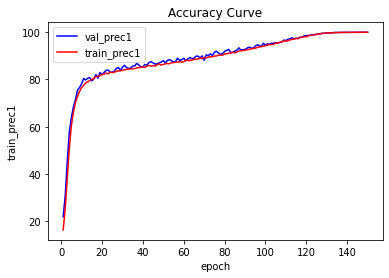

In [20]:
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val_prec1', color='b')
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train_prec1', color='r').set_title('Accuracy Curve')

Text(0.5, 1.0, 'Loss Curve')

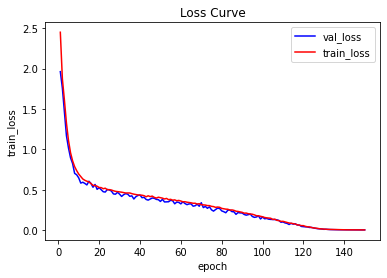

In [21]:
sns.lineplot(data=logs, x='epoch', y='val_loss', label='val_loss', color='b')
sns.lineplot(data=logs, x='epoch', y='train_loss', label='train_loss', color='r').set_title('Loss Curve')

# Load in Model

In [23]:
model_path = open('/home/pstefanou/cifar-10-vgg11/41e47676-0d3f-4433-b7c4-9a4008e38662/checkpoint.pt.best',"rb")
base_model = vgg11()
checkpoint_dict = ch.load('/home/pstefanou/cifar-10-vgg11/41e47676-0d3f-4433-b7c4-9a4008e38662/checkpoint.pt.best')
base_model.load_state_dict(checkpoint_dict['model'])

<All keys matched successfully>

# Test Accuracy

In [24]:
test_store = store.Store(args.out_dir)
results = train.eval_model(args, base_model, test_loader, test_store)
results

{'test_prec1': tensor(91.1700, device='cuda:0'),
 'test_loss': 0.36373048400878905,
 'time': 1.1794376373291016}